In [11]:
%matplotlib inline
import requests as re
from bs4 import BeautifulSoup
from csv import writer
from datetime import date, timedelta
import pandas as pd
import numpy as np
import warnings
# for latex equations
from IPython.display import Math, Latex
# for displaying images
from IPython.core.display import Image
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell

import seaborn as sns
# settings for seaborn plotting style
sns.set(color_codes=True)
# settings for seaborn plot sizes
sns.set(rc={'figure.figsize':(5,5)})


InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')

pd.set_option('display.width', 1000000)
pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3)


fund_id_map = {
    'AXIS': 53,
    'CANARA': 32,
    'MIRAE': 45,
    'PPFAS': 64,
    'QUANT': 13,
    'ICICI': 20,
    'MOTI': 55,
#     'UTI': 28,
    'NIPPON': 21,
    'SBI': 22,
    'HDFC': 9,
    'EDELWEISS': 47,
    'KOTAK':17
} 

fund_scheme_map = {    
    'AXIS': { 
        'axis_long_term_equity': 120503,
        'axis_small_cap': 125354,
#         'axis_mid_cap': 120505,
#         'axis_flexi_cap': 141925,        
#         'axis_bluechip': 120465
    },
    'CANARA': {
        'canara_emerging_equities': 118278,
#         'canara_small_cap': 146130,
#         'canara_bluchip': 118269,
#         'canara_tax_saver': 118285
    },
    'MIRAE': {
        'mirae_tax_saver': 135781,
        'mirae_emerging_bluchip': 118834,
#         'mirae_large_cap': 107578
    },
    'PPFAS': {
        'ppfas_flexi_cap': 122639
    },
    'QUANT': {
        'quant_active_fund': 120823,
        'quant_small_cap': 120828,
#         'quant_dynamic_asset': 151713
    },
    'ICICI': {
        'icici_value_discovery': 120323,
        'icici_balanced_advan_fund': 120377
    },
    'MOTI': {
#         'moti_nifty_200_momentum': 149800
        'moti_midcap_fund': 127042
    },
#     'UTI': {
#         'uti_midcap_quality_50': 150313
#     },
    'NIPPON': {
#         'nippon_alpha_low_volatility': 150487,
        'nippon_value_fund': 118784
    },
    'SBI': {
        'sbi_small_cap': 125497,
        'sbi_large_and_mid': 119721,
        'sbi_bluechip': 119598
    },
    'HDFC': {
        'hdfc_balanced_advantage_fund': 118968,
        'hdfc_flexicap_fund': 118955
    },
    'EDELWEISS': {
        'edelweiss_balanced_adv_fund': 118615
    },
    'KOTAK': {
        'kotak_emerging_equities_scheme': 119775,
        'kotak_flexicap_fund': 120166
    }
}



In [2]:

st_dt = date(2018, 9, 1)
en_dt = st_dt.replace(year=st_dt.year +4)



def fetch_and_write():
    for fund, mfID in fund_id_map.items():
        for scheme ,scID in fund_scheme_map[fund].items():
            
            start_dt = st_dt
            end_dt = en_dt
            
            while start_dt < date.today():
                resp = fetch(mfID, scID, start_dt, end_dt)            
                soup = BeautifulSoup(resp.content)            
                
                start_dt = end_dt + timedelta(days =1)
                end_dt = end_dt.replace(year = end_dt.year +4)
                
                
                for child in soup.find_all('tbody')[0].find_all('tr'):
                    td_list = child.find_all('td')

                    if(len(td_list) !=4 ):
                       continue

                    x = [td_list[3].string, td_list[0].string]
                    with open("{}.csv".format(scheme), 'a') as f_object:
                        writer_object = writer(f_object)
                        writer_object.writerow(x)
                        f_object.close()                                                
                
            
def fetch(mfID, scID, sDate, eDate):
    url = 'https://www.amfiindia.com/modules/NavHistoryPeriod'    
    
    data = {
      'mfID': mfID,
      'scID': scID,
      'fDate': sDate.strftime('%d-%b-%Y'),
      'tDate': eDate.strftime('%d-%b-%Y'),
    }

    return re.post(url = url, data =data)
    

fetch_and_write()


In [12]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

out = pd.DataFrame(columns=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']);

final_df = pd.DataFrame()

def multi_period_return(period_returns):
 return np.prod(period_returns + 1) - 1

for fund, mfID in fund_id_map.items():
    for scheme ,scID in fund_scheme_map[fund].items():
        df = pd.read_csv('{}.csv'.format(scheme), names= ['date', 'nav'], parse_dates=['date'], index_col = ['date'])
        df['nav'] = df['nav']/df['nav'].max()
        pr = df.pct_change()
  
        df['1yr_roll_ret'] = pr.rolling('360D').apply(multi_period_return).mul(100)
        df['2yr_roll_ret'] = pr.rolling('720D').apply(multi_period_return).mul(100)
        df['3yr_roll_ret'] = pr.rolling('1080D').apply(multi_period_return).mul(100)
        df['5yr_roll_ret'] = pr.rolling('1800D').apply(multi_period_return).mul(100)
        df['cum_return']   = pr.add(1).cumprod().sub(1).mul(100)
        df['fund']=scheme
        final_df = pd.concat([final_df, df])
        
        
#         out.loc[scheme] = df['1yr_roll_ret'].iloc[245:].describe().values

final_df = final_df.iloc[1:,:].reset_index()

In [13]:
durations = [
#     '1yr_roll_ret', '2yr_roll_ret', 
    '3yr_roll_ret', '5yr_roll_ret']

dates     = [
#     '04-01-2016','04-01-2018',
    '01-09-2021','01-09-2023']

tax_free_rates = [ 
#     7, 14.49,
    22.05, 40.26]   # @7  %

desired_rates = [
#     14, 29.96, 
    48.15, 92.54  ] # @14 %


In [14]:
for idx, ret in enumerate(durations):
    ans = pd.DataFrame()
    for fund, mfID in fund_id_map.items():
        for scheme ,scID in fund_scheme_map[fund].items():
    #         data = final_df[final_df['fund'] == scheme]['1yr_roll_ret'].describe()

    #         data['1yr_roll_ret'] = final_df[final_df['fund'] == scheme]['1yr_roll_ret'].describe()
    #         data['2yr_roll_ret'] = final_df[final_df['fund'] == scheme]['2yr_roll_ret'].describe()
    #         data['3yr_roll_ret'] = final_df[final_df['fund'] == scheme]['3yr_roll_ret'].describe()        
    #         data['fund'] = scheme        
              data = final_df[ (final_df['fund'] == scheme) & (final_df['date'] >= dates[idx]) ][ret].describe()
              data = pd.DataFrame(data).transpose()
              data['fund'] = scheme
#               display(data)
              ans = pd.concat([ans, data])
    #           
    print(f"return for duration: {ret}")
    ans = ans.reset_index()
    ans = ans.set_index(['fund','index'])
    ans = ans.loc[:, ~ans.columns.isin(['count'])]
    display(ans[['min','max','25%','mean','50%','75%','std']].sort_values(by=['min','std'], ascending=[False, True] ))
    print("")


return for duration: 3yr_roll_ret


,,min,max,25%,mean,50%,75%,std
fund,index,,,,,,,
quant_active_fund,3yr_roll_ret,43.736,260.921,113.905,133.424,140.028,155.220,35.508
axis_small_cap,3yr_roll_ret,41.987,184.761,100.607,119.076,123.614,143.732,31.814
ppfas_flexi_cap,3yr_roll_ret,41.639,163.231,81.754,93.097,91.575,107.451,22.844
quant_small_cap,3yr_roll_ret,38.872,433.310,151.543,198.224,196.400,251.824,78.760
mirae_emerging_bluchip,3yr_roll_ret,38.816,160.029,70.802,85.564,83.517,100.158,20.418
mirae_tax_saver,3yr_roll_ret,36.210,164.421,68.311,82.857,79.767,98.336,20.906
sbi_small_cap,3yr_roll_ret,29.723,201.970,94.899,110.108,116.098,132.331,35.318
edelweiss_balanced_adv_fund,3yr_roll_ret,29.299,79.742,47.960,54.871,56.437,61.890,10.067
kotak_emerging_equities_scheme,3yr_roll_ret,28.812,182.756,78.431,98.877,101.973,118.923,30.789



return for duration: 5yr_roll_ret


,,min,max,25%,mean,50%,75%,std
fund,index,,,,,,,
quant_small_cap,5yr_roll_ret,171.557,298.131,191.888,229.108,224.736,265.984,37.963
axis_small_cap,5yr_roll_ret,126.029,242.699,138.575,174.138,169.170,214.762,37.114
quant_active_fund,5yr_roll_ret,124.613,228.390,140.669,167.668,158.861,194.891,29.469
sbi_small_cap,5yr_roll_ret,97.514,203.821,108.655,138.671,128.477,176.810,33.640
ppfas_flexi_cap,5yr_roll_ret,93.536,176.805,102.095,127.324,123.056,147.010,25.693
kotak_emerging_equities_scheme,5yr_roll_ret,92.612,192.900,100.637,128.538,119.930,164.667,31.328
moti_midcap_fund,5yr_roll_ret,85.311,208.171,93.846,129.662,121.280,176.642,38.935
mirae_emerging_bluchip,5yr_roll_ret,80.421,165.992,89.617,111.457,103.925,134.558,23.979
mirae_tax_saver,5yr_roll_ret,79.422,155.096,88.144,107.703,101.953,127.374,21.273


Probability of return greater than risk free: axis_long_term_equity : 3yr_roll_ret : 0.56
Probability of return greater than risk free: axis_small_cap : 3yr_roll_ret : 0.97
Probability of return greater than risk free: canara_emerging_equities : 3yr_roll_ret : 0.85
Probability of return greater than risk free: mirae_tax_saver : 3yr_roll_ret : 0.95
Probability of return greater than risk free: mirae_emerging_bluchip : 3yr_roll_ret : 0.97
Probability of return greater than risk free: ppfas_flexi_cap : 3yr_roll_ret : 0.96
Probability of return greater than risk free: quant_active_fund : 3yr_roll_ret : 0.98
Probability of return greater than risk free: quant_small_cap : 3yr_roll_ret : 0.97
Probability of return greater than risk free: icici_value_discovery : 3yr_roll_ret : 0.8
Probability of return greater than risk free: icici_balanced_advan_fund : 3yr_roll_ret : 0.33
Probability of return greater than risk free: moti_midcap_fund : 3yr_roll_ret : 0.8
Probability of return greater than ris

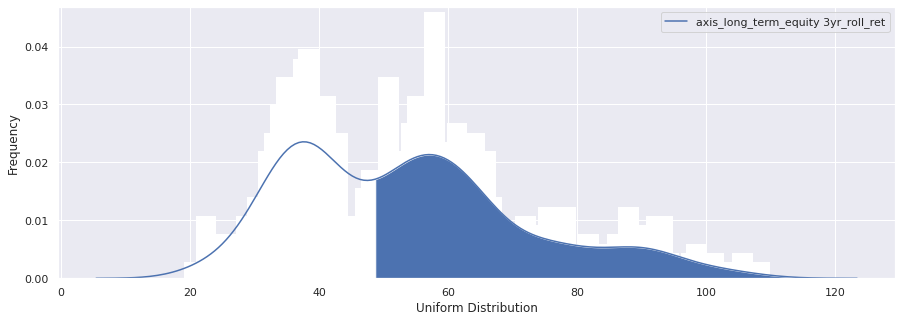

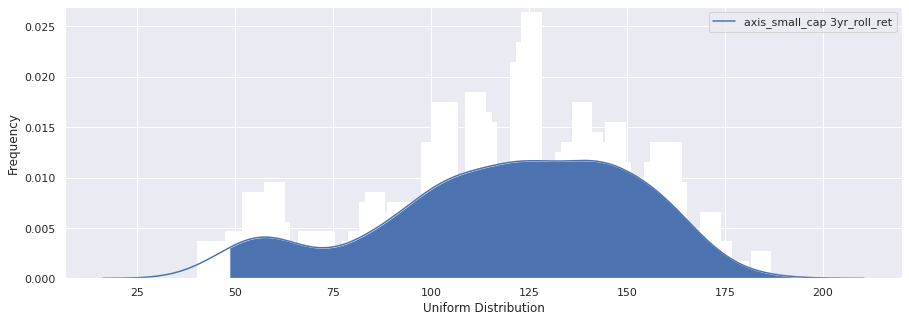

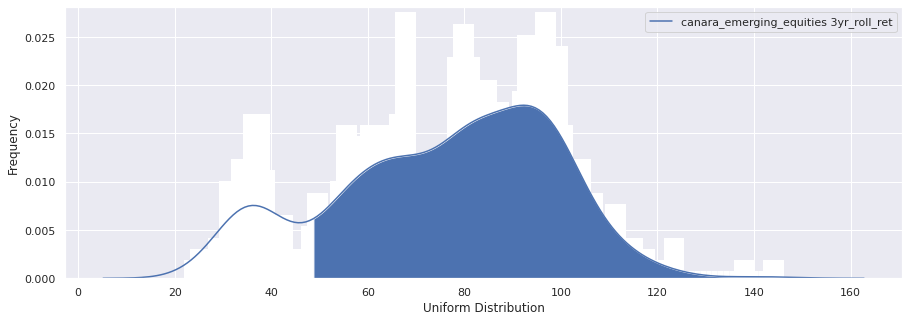

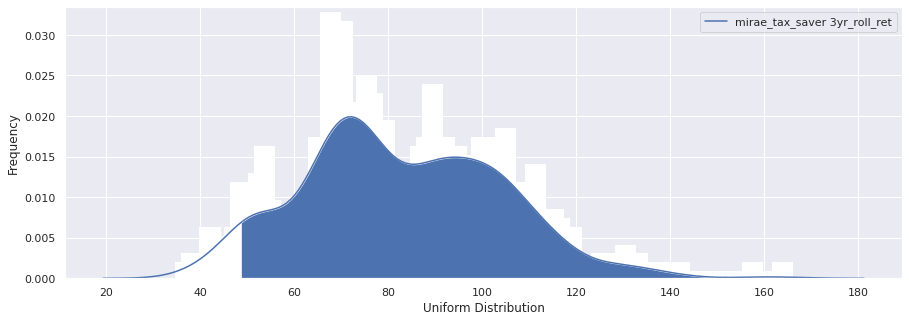

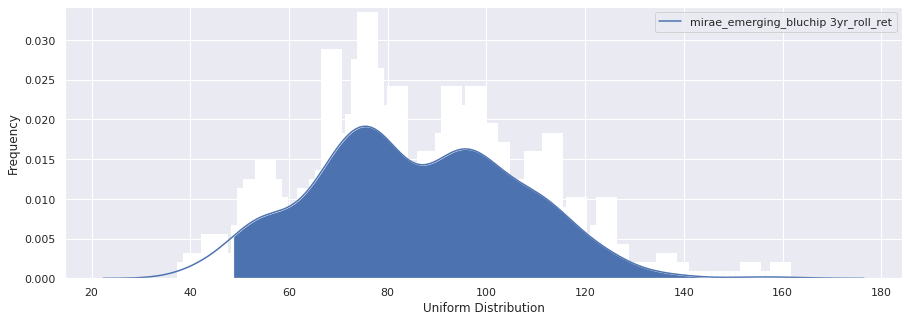

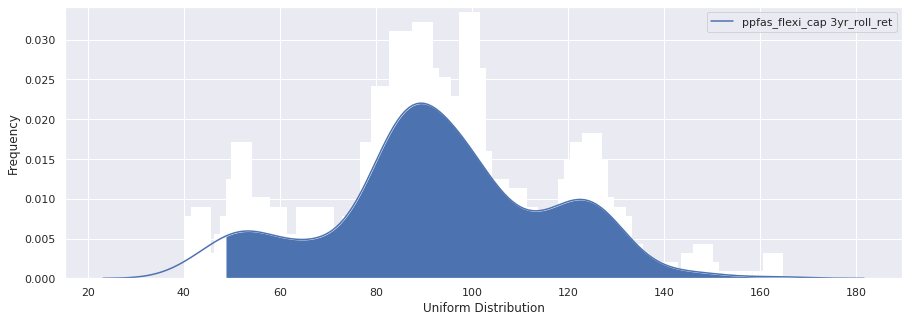

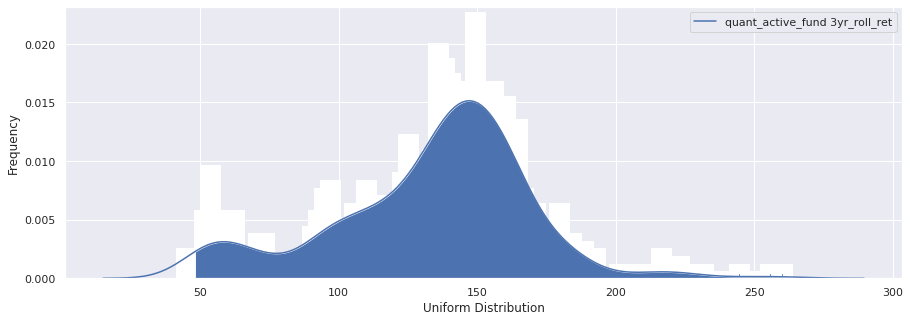

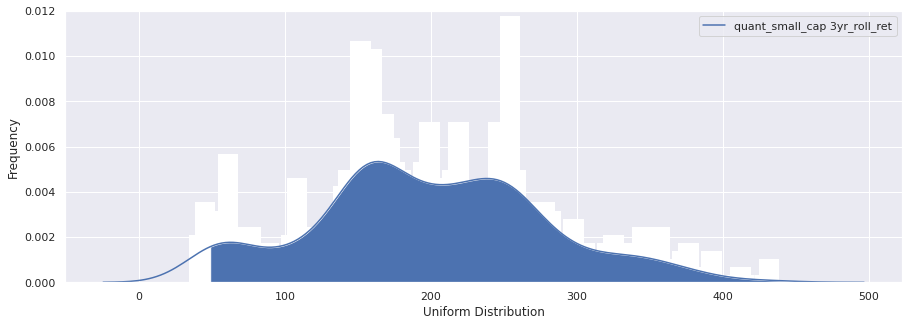

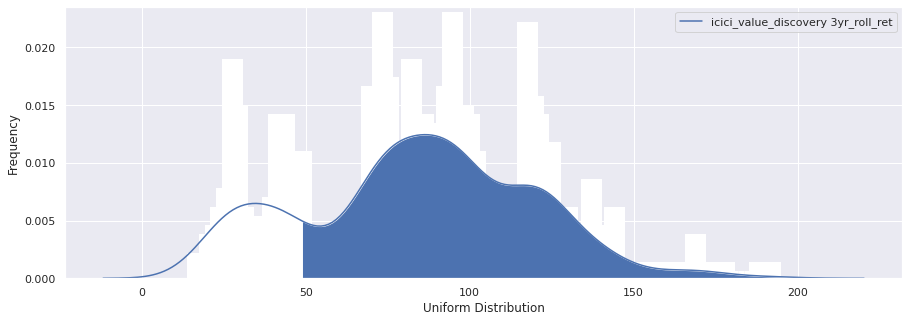

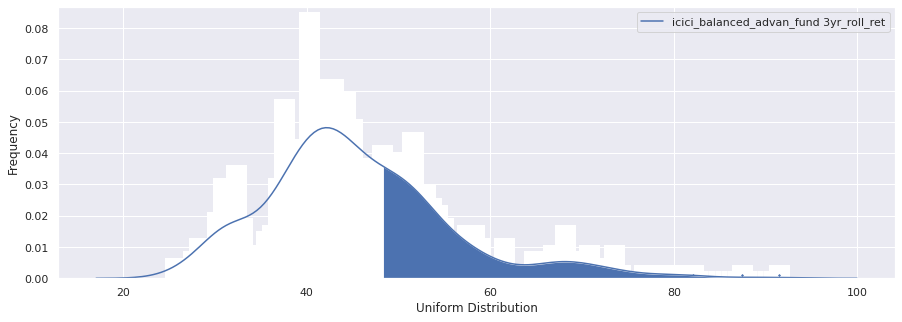

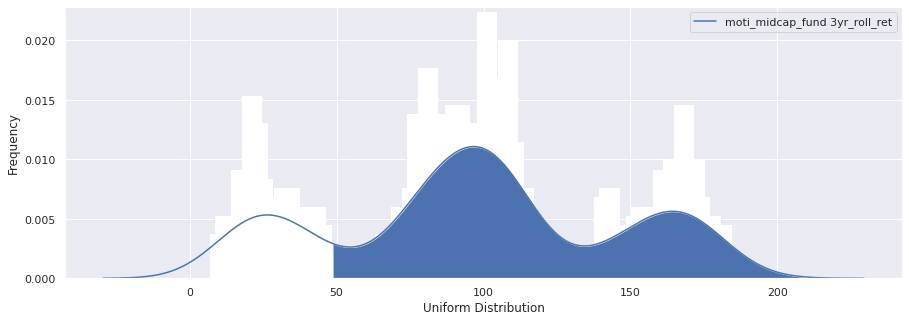

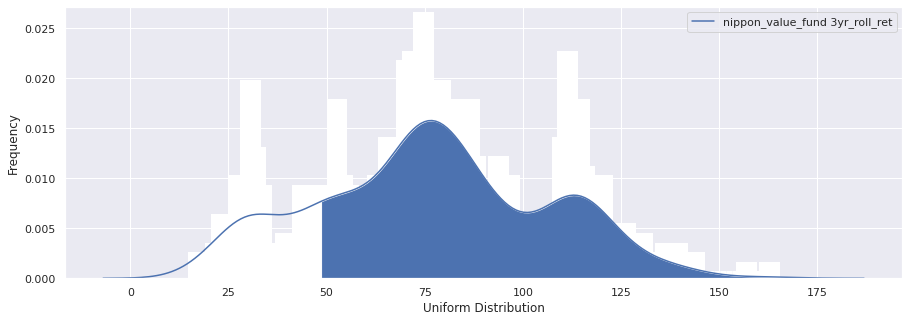

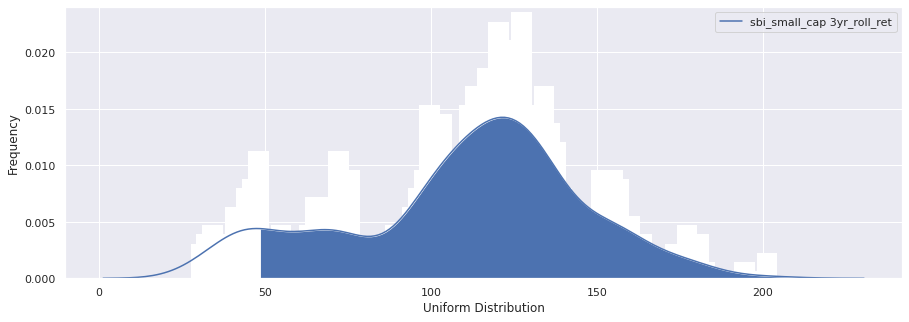

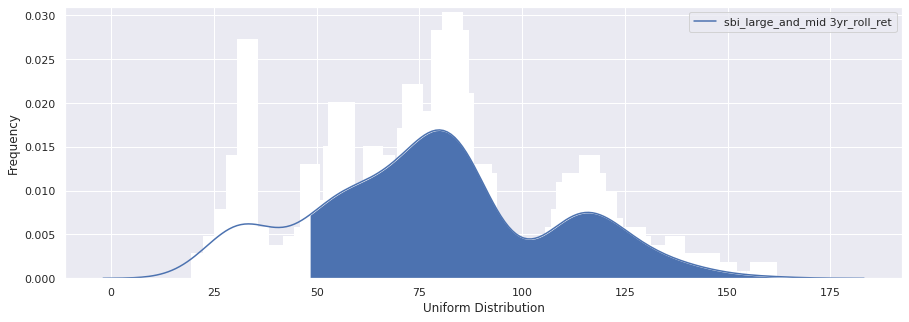

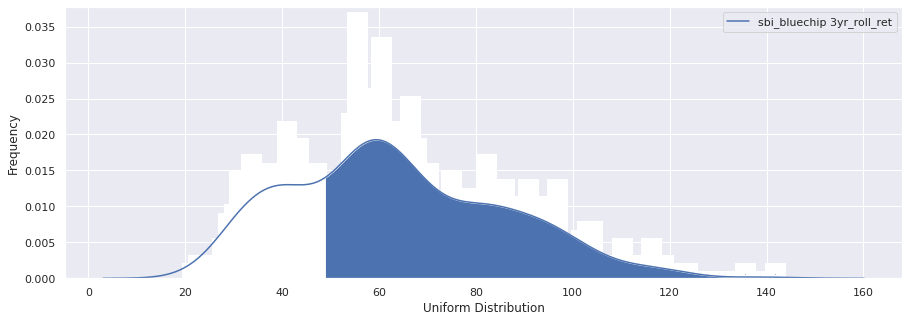

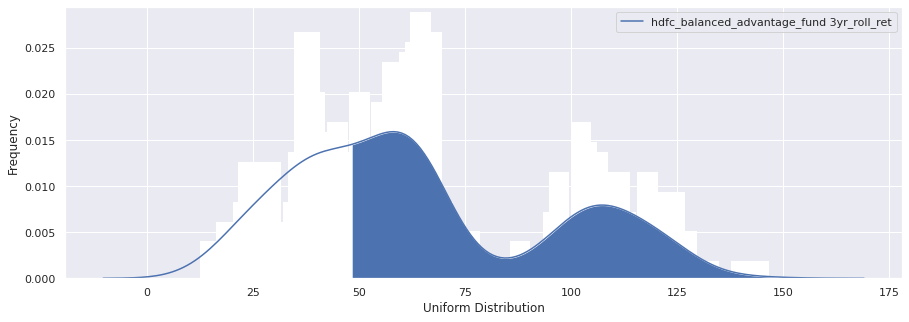

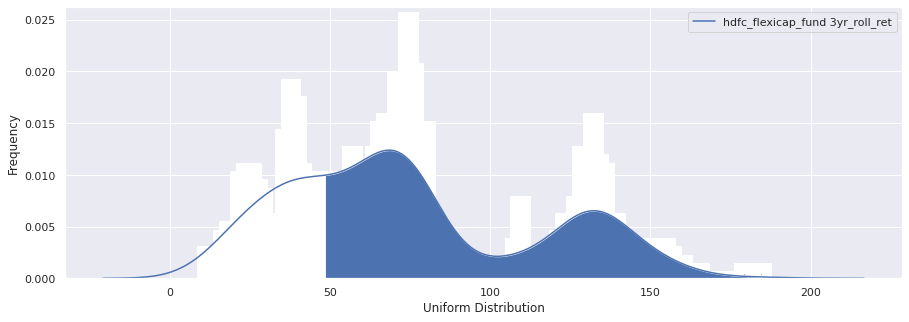

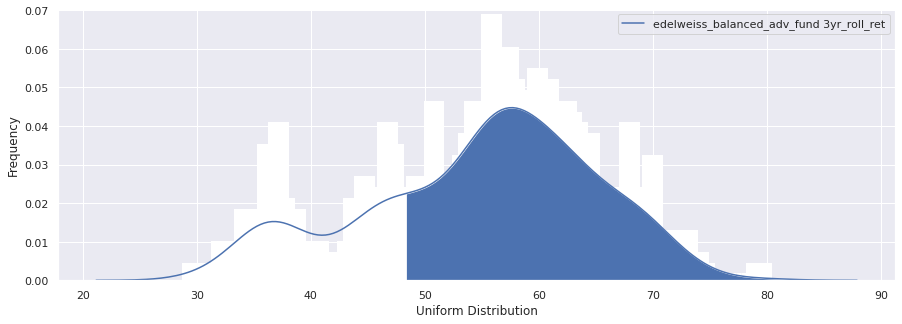

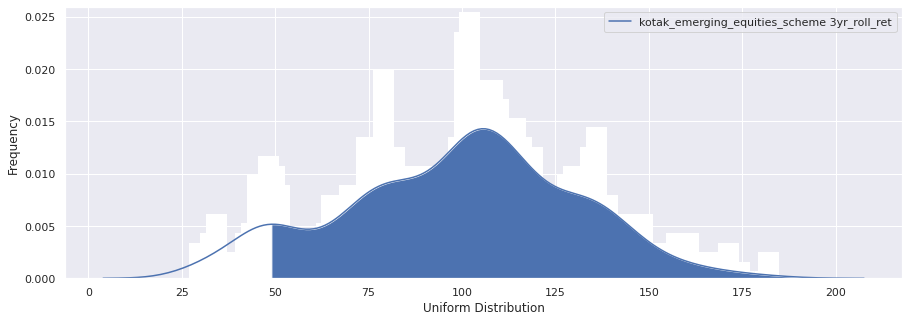

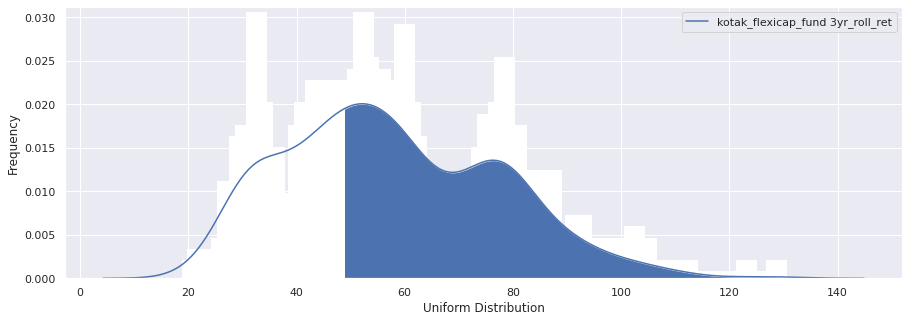

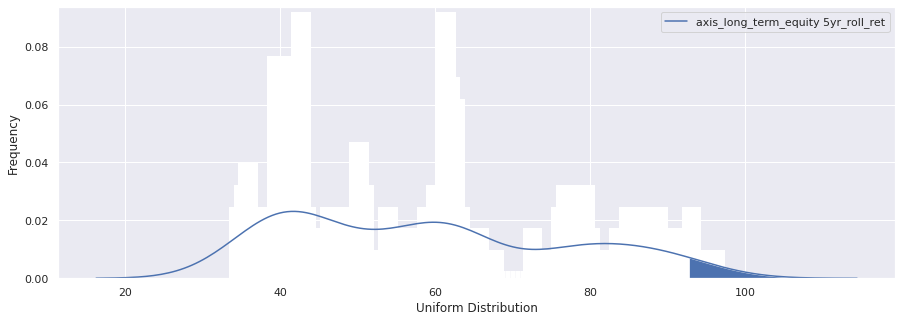

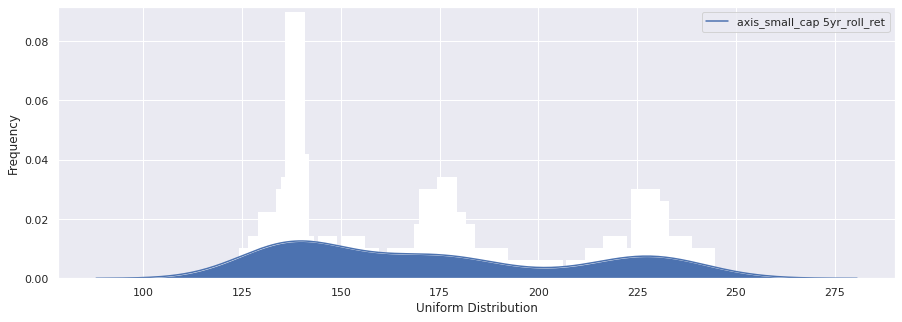

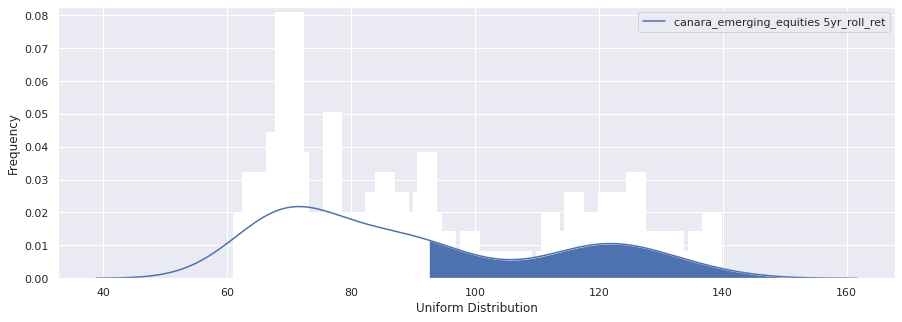

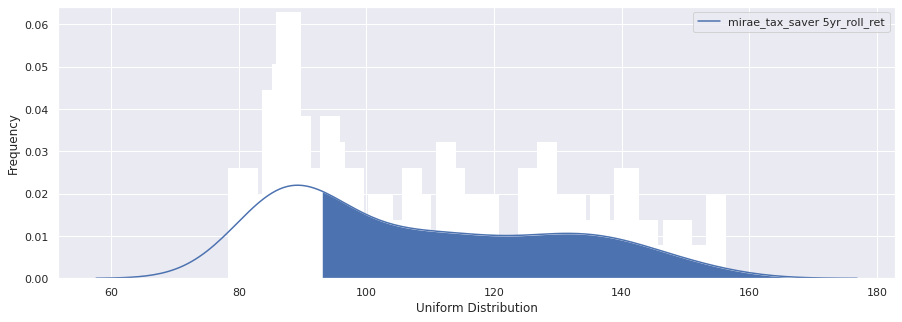

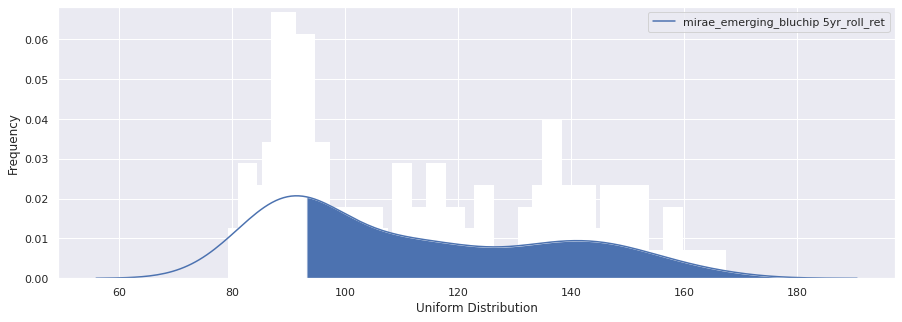

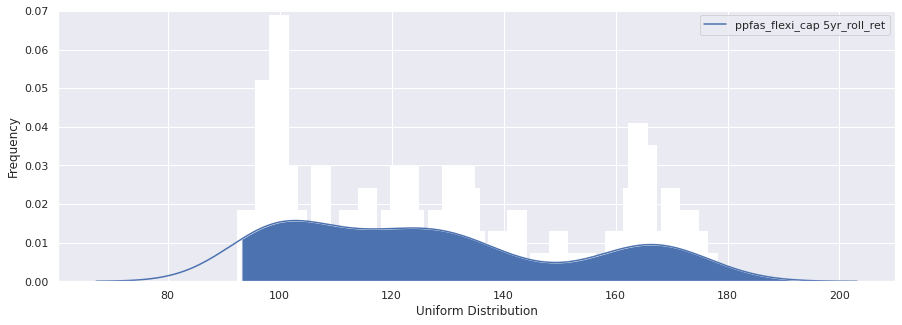

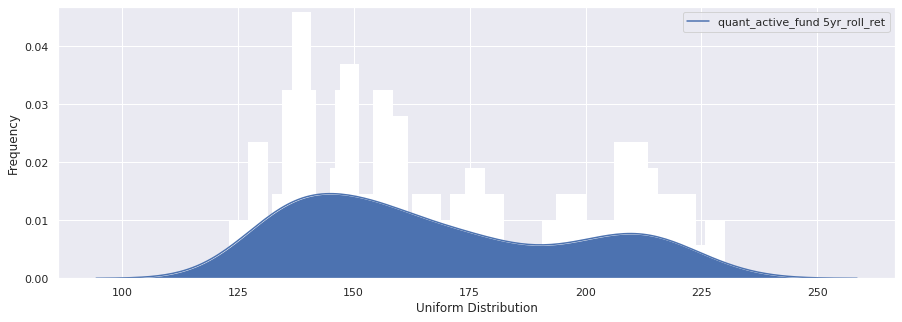

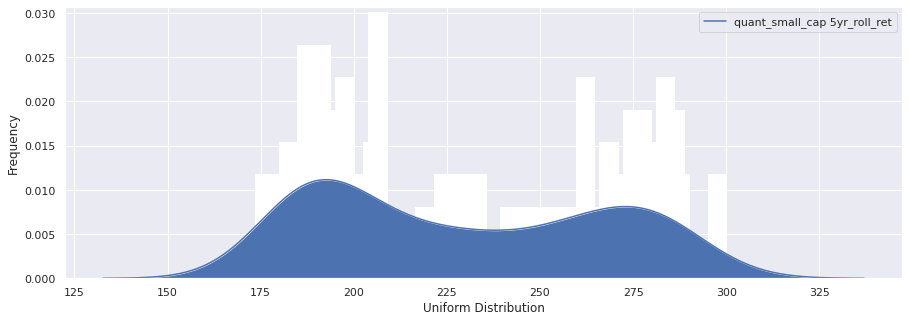

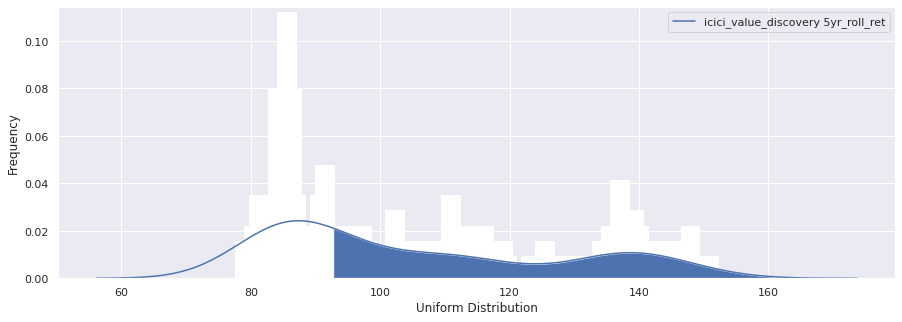

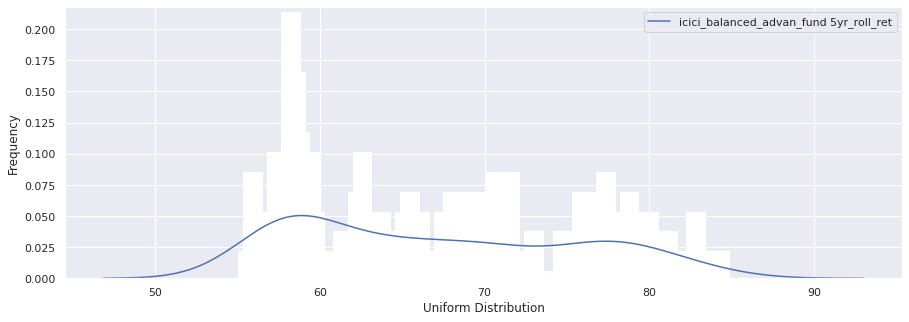

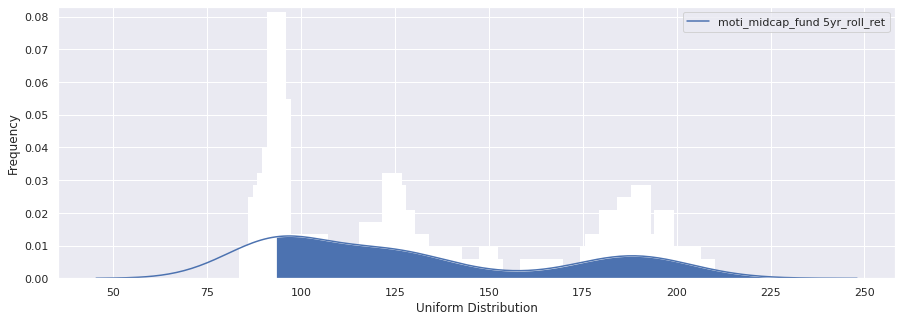

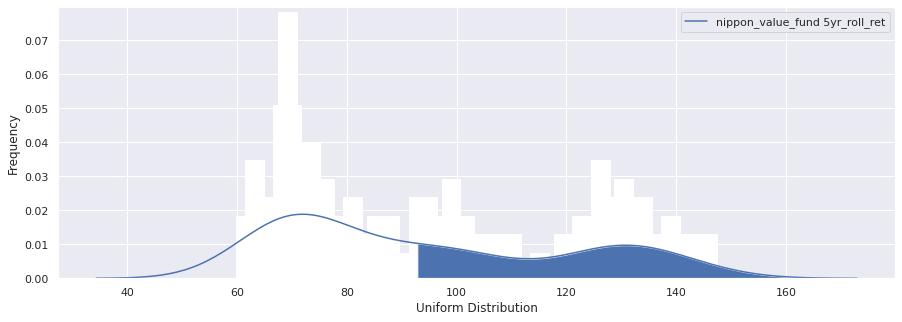

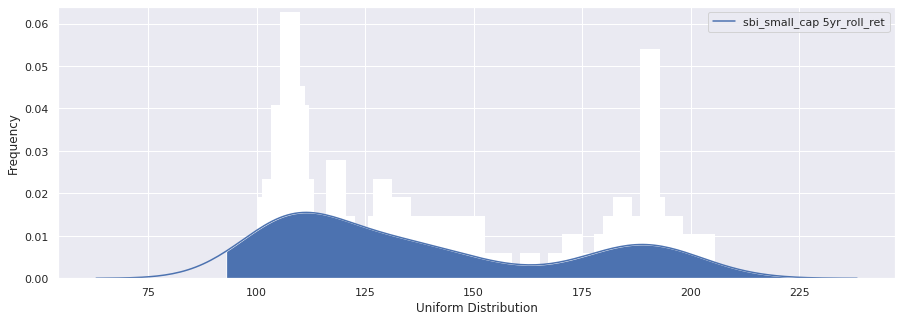

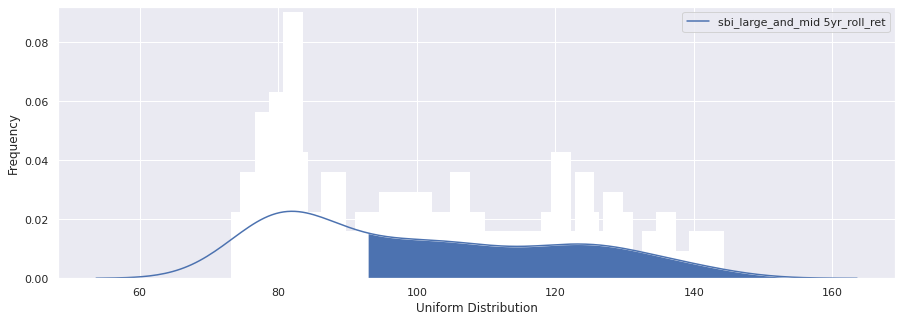

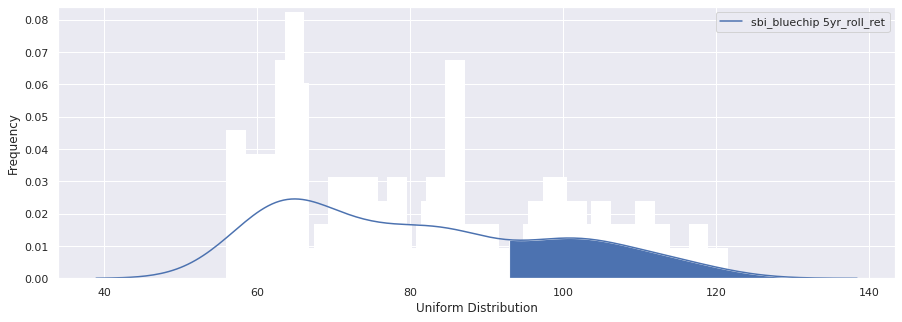

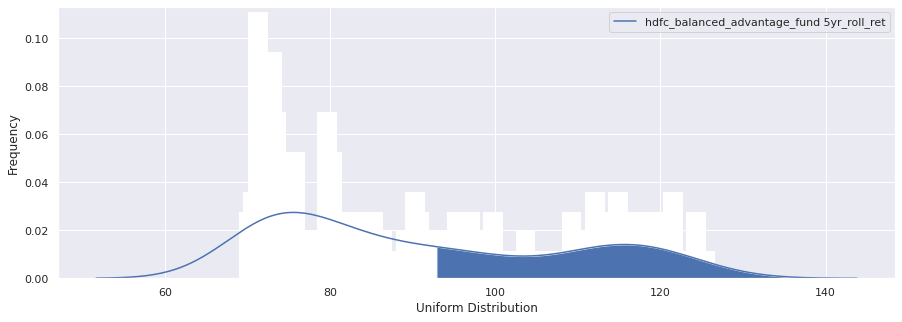

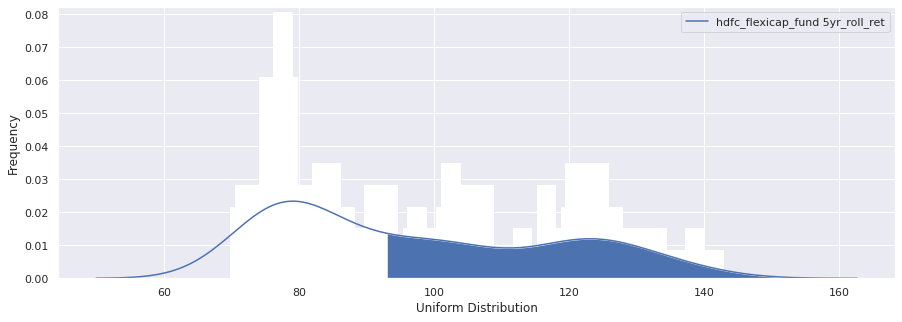

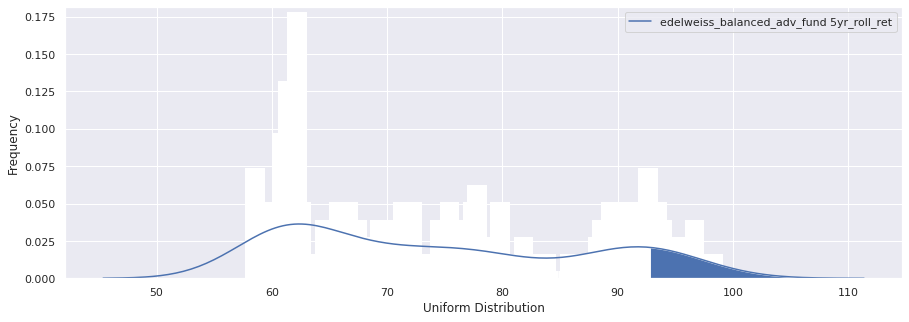

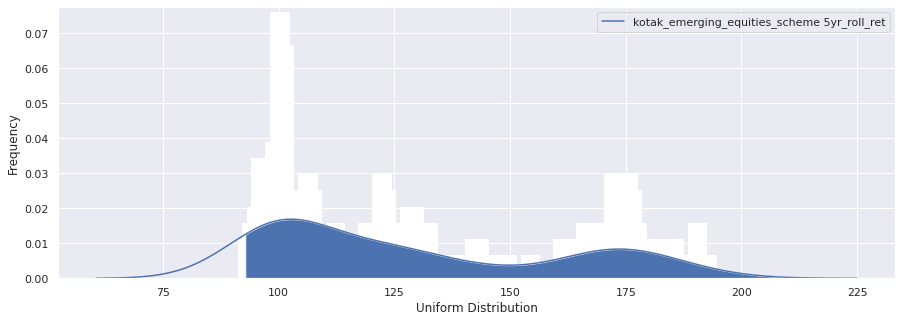

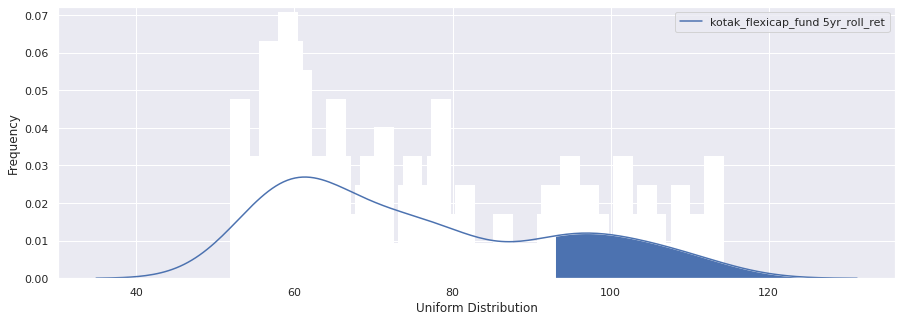

In [20]:
prob_df = pd.DataFrame()
for idx, ret in enumerate(durations):
    for fund, mfID in fund_id_map.items():
        funds=[]
        for scheme ,scID in fund_scheme_map[fund].items():        
            fig = plt.figure(figsize=(15, 5))
            values = final_df[ (final_df['fund'] == scheme) & (final_df['date'] >= dates[idx]) ][ret].to_numpy()
            ax = sns.distplot(values,
                              bins=100,
                              kde=True,                          
                              hist_kws={"linewidth": 15,'alpha':1});

            kde_lines = ax.get_lines()[-1]
            kde_x, kde_y = kde_lines.get_data()            
            
            mask = ( kde_x > desired_rates[idx] )
            filled_x, filled_y = kde_x[mask], kde_y[mask]
            ax.fill_between(filled_x, y1=filled_y);
            area = np.trapz(filled_y, filled_x)
            
            print(f"Probability of return greater than risk free: {scheme} : {ret} : {area.round(2)}")

            funds.append(scheme)  
            ax.set(xlabel='Uniform Distribution', ylabel='Frequency');
            plt.legend(labels=[f"{scheme} {ret}"]);
            # plt.axvline(x=0, linewidth=3, color='red', linestyle='--')
        

plt.show();

In [16]:
# for fund, mfID in fund_id_map.items():
#     for scheme ,scID in fund_scheme_map[fund].items():

pd.qcut(final_df[ (final_df['fund'] == 'ppfas_flexi_cap') & (final_df['date'] > '01-09-2019') ]['3yr_roll_ret'], q=7).value_counts()
pd.cut(final_df[ (final_df['fund'] == 'ppfas_flexi_cap') & (final_df['date'] > '01-09-2019') ]['3yr_roll_ret'], bins=7).value_counts()

3yr_roll_ret
(-23.48, -2.39]       180
(5.053, 38.861]       180
(81.381, 91.186]      180
(106.812, 163.231]    180
(-2.39, 5.053]        179
(38.861, 81.381]      179
(91.186, 106.812]     179
Name: count, dtype: int64

3yr_roll_ret
(83.212, 109.885]     348
(-23.666, 3.194]      306
(3.194, 29.866]       202
(109.885, 136.558]    154
(56.539, 83.212]      128
(29.866, 56.539]      107
(136.558, 163.231]     12
Name: count, dtype: int64

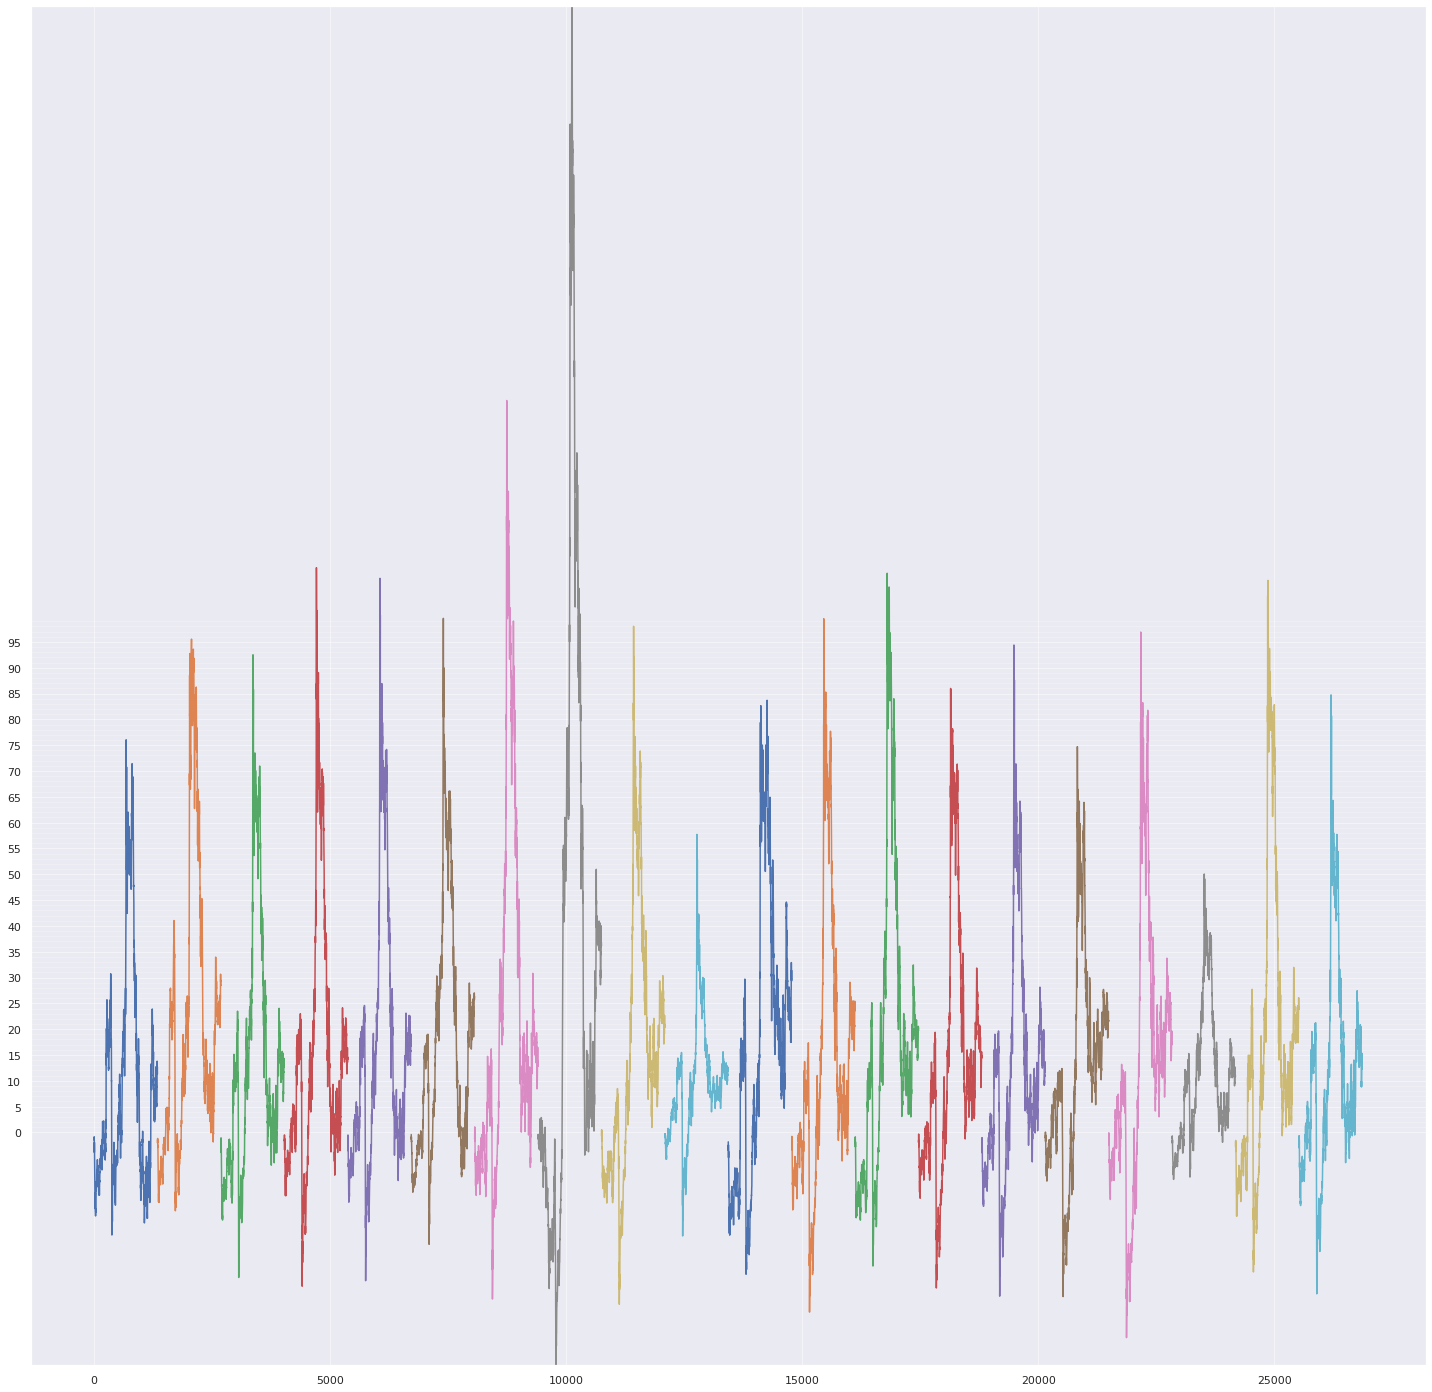

In [21]:

pdf = final_df


fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(1, 1, 1);
plt.ylim(pdf["1yr_roll_ret"].min(), pdf["1yr_roll_ret"].max())
major_ticks = np.arange(0, 100, 5)
minor_ticks = np.arange(0, 100, 1)

# ax.set_xticks(major_ticks)
# ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks);
ax.set_yticks(minor_ticks, minor=True);

# And a corresponding grid
ax.grid(which='both');

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2);
ax.grid(which='major', alpha=0.5);


for fund, mfID in fund_id_map.items():
    for scheme ,scID in fund_scheme_map[fund].items():

        plt.plot(
            pdf[pdf['fund']==scheme].index,
            pdf[pdf['fund']==scheme]["1yr_roll_ret"]
        )


# plt.plot(
#     pdf.iloc[246:].index,
#     pdf.iloc[246:]["2yr_roll_ret"]
# )

# plt.plot(
#     pdf.iloc[492:].index,
#     pdf.iloc[492:]["3yr_roll_ret"]
# )


# plt.axhline(y = pdf["1yr_roll_ret"].mean())
# plt.axhline(y = pdf.iloc[246:]["2yr_roll_ret"].mean())
# plt.axhline(y = 0)


# plt.plot(
#     pdf.index,
#     pdf["cum_return"]
# )


plt.show();

In [27]:
## https://www.hdfcpension.com/nav/nav-history/

import random
import string

nps_start_dt = date(2016, 8, 1)
nps_end_dt = date.today()
char_set = string.ascii_uppercase + string.digits
#nonce = ''.join(random.sample(char_set*10, 10))
    
def fetch_nps():
    nps_url = 'https://www.hdfcpension.com/wp-admin/admin-ajax.php'
    
    nps_data = {
      'action': 'nav_get',
      'nonce': 'ab08f277c5',
      'from_date': nps_start_dt.strftime('%Y-%m-%d'),
      'to_date': nps_end_dt.strftime('%Y-%m-%d'),
    }

    return re.post(url = nps_url, data =nps_data)
    
nps_res = fetch_nps()
soup = BeautifulSoup(nps_res.content)
print(soup.get_text())
#print(soup.find_all('tr'))



    

{"success":false,"data":"Nonce is incorrect"}
